In [1]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import pandahouse
import datetime as dt
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline

plt.style.use('seaborn-whitegrid')

sns.set(font_scale = 1.25,
        style = 'whitegrid',
        rc = {'figure.figsize': (14, 5)})

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Всплеск уникальных пользователей с рекламным источником трафика произошел 2022-09-16, это можно видеть на графике тут: http://superset.lab.karpov.courses/r/2194

Достанем данные пользователей, которые в 2022-09-16 впервые зашли в приложение.

In [3]:
# Выгрузим данные всех юзеров, которые пришли в приложение 2022-09-16.
query = '''select * 
from 
    (select 
        user_id, 
        toDate(time) as time_of_action,
        source
    from simulator_20220920.feed_actions) as l
inner join 
    (select 
        user_id,
        toDate(min(time)) as first_visit
    from simulator_20220920.feed_actions
    group by user_id) as r
using user_id
where first_visit = toDateTime('2022-09-16')'''

In [4]:
df = pandahouse.read_clickhouse(query, connection = connection)

In [5]:
df.head(3)

,user_id,time_of_action,source,first_visit
0,145927,2022-09-17,organic,2022-09-16
1,144690,2022-09-17,organic,2022-09-16
2,146896,2022-09-17,organic,2022-09-16


In [6]:
df.shape

(397503, 4)

In [7]:
# Сколько уникальных юзеров пришло в приложение 2022-09-16 в разрезе по источнику трафика
df.groupby('source', as_index = False).agg({'user_id': pd.Series.nunique})

,source,user_id
0,ads,3688
1,organic,756


Видно, что в этот день через рекламу пришло в несколько раз больше новых пользователей.

In [9]:
# Создадим переменную, фиксирующую разницу между датой первого визита и датой действия в днях
df['day_after'] = (df.time_of_action - df.first_visit).dt.days
df.head(3)

,user_id,time_of_action,source,first_visit,day_after
0,145927,2022-09-17,organic,2022-09-16,1
1,144690,2022-09-17,organic,2022-09-16,1
2,146896,2022-09-17,organic,2022-09-16,1


Создадим два датафрейма - один с рекламными, другой с органическими пользователями.

In [10]:
ads_df = df.query('source == "ads"') \
    .groupby(['first_visit', 'day_after'], as_index = False) \
    .agg({'user_id': pd.Series.nunique}) \
    .rename(columns = {'user_id': 'amount_of_unique_users'})

organic_df = df.query('source == "organic"') \
    .groupby(['first_visit', 'day_after'], as_index = False) \
    .agg({'user_id': pd.Series.nunique}) \
    .rename(columns = {'user_id': 'amount_of_unique_users'})

In [11]:
ads_df.head(3)

,first_visit,day_after,amount_of_unique_users
0,2022-09-16,0,3688
1,2022-09-16,1,106
2,2022-09-16,2,124


In [12]:
organic_df.head(3)

,first_visit,day_after,amount_of_unique_users
0,2022-09-16,0,756
1,2022-09-16,1,256
2,2022-09-16,2,260


Визуализируем ритеншен

<AxesSubplot:xlabel='day_after', ylabel='amount_of_unique_users'>

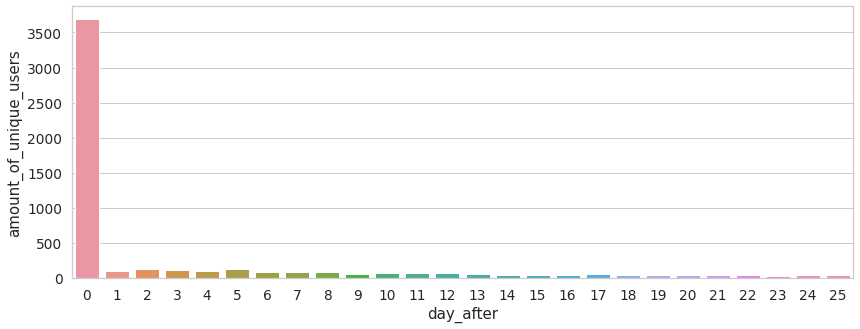

In [13]:
# Ритеншен рекламных пользователей
sns.barplot(data = ads_df, x = "day_after", y = "amount_of_unique_users")

<AxesSubplot:xlabel='day_after', ylabel='amount_of_unique_users'>

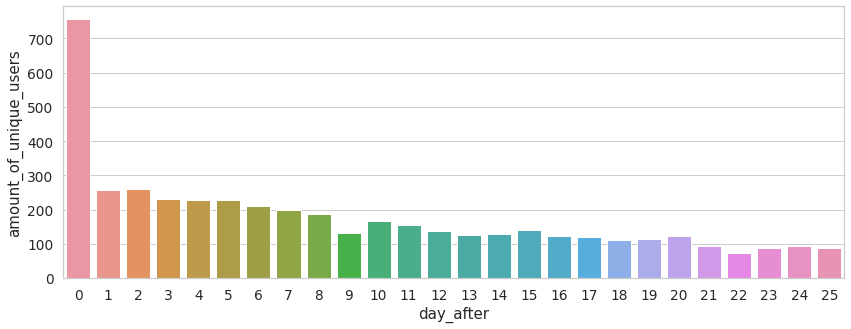

In [14]:
# Ритеншен органических пользователей
sns.barplot(data = organic_df, x = "day_after", y = "amount_of_unique_users")

Различия довольно сильные - ритеншн 1-го, 7-го и 21-го дня среди рекламных пользователей ниже и в абсолютных, и в относительных значениях.

In [15]:
# Переведем показатели в проценты от 0 дня
ads_retention = ads_df.iloc[:, 2].divide(ads_df.iloc[:, 2].max()) * 100
organic_retention = organic_df.iloc[:, 2].divide(organic_df.iloc[:, 2].max()) * 100

Проверим различия на статистическую значимость. Наблюдений мало (<30), распределения отличаются от нормального, поэтому будем использовать непараметрику.

In [16]:
# Проверка распределений на нормальность
print(stats.shapiro(organic_retention))
print(stats.shapiro(ads_retention))

ShapiroResult(statistic=0.5818576812744141, pvalue=1.8388874423180823e-07)
ShapiroResult(statistic=0.22937703132629395, pvalue=1.165190305352226e-10)


In [17]:
stats.mannwhitneyu(ads_retention, organic_retention, alternative='two-sided')

MannwhitneyuResult(statistic=25.5, pvalue=1.1242999836366256e-08)

Вывод: существуют статистически значимые различия в показателях ритеншена для пользователей с различным источником трафика - у пользователей, пришедших в продукт в результате рекламной кампании, ритеншен значительно ниже в сравнении с органическими пользователями. Таким образом можно заключить, что качество рекламного трафика низкое, и пользователи, которые были привлечены в продукт рекламной кампанией, почти не возвращались обратно.